In [2]:
import numpy as np
import torch 
import gym
from torch import nn
import matplotlib.pyplot as plt


In [3]:
#conversion function: numpy arrays to tensors
def t(x):
    return torch.from_numpy(x).float()
    

In [5]:
# categorical actions only, Actor module
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64,32),
            nn.Tanh(),
            nn.Linear(32, n_actions),
            nn.Softmax()
        )
    
    def forward(self, x):
        return self.model(x)


In [6]:
#critic network
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,1)
        )
    def forward(self, X):
        return self.model(X)
    

In [7]:
env = gym.make("CartPole-v1")


/home/bunnybhaiya/.local/lib/python3.10/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/bunnybhaiya/.local/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [8]:
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)
adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-3)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)
gamma  = 0.99

In [9]:
epsiode_rewards = []
for i in range(500):
    done = False
    total_reward = 0
    state = env.reset()

    while not done:
        # Obtaining probabilities of different actions for a state.
        probs = actor(t(state)) 
        # Creating a probability distribution over actions to sample from.
        dist = torch.distributions.Categorical(probs=probs)
        # Sampling action at random from the distribution
        action = dist.sample()

        next_state, reward, done, info = env.step(action.detach().data.numpy())
        advantage = reward + (1-done)*gamma*critic(t(next_state)) - critic(t(state))

        total_reward += reward
        state = next_state

        critic_loss = advantage.pow(2).mean(0)
        adam_critic.zero_grad()
        critic_loss.backward()
        adam_critic.step()

        actor_loss = -dist.log_prob(action)*advantage.detach()
        adam_actor.zero_grad()
        actor_loss.backward()
        adam_actor.step()
    
    epsiode_rewards.append(total_reward)

        

/home/bunnybhaiya/anaconda3/envs/rl/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


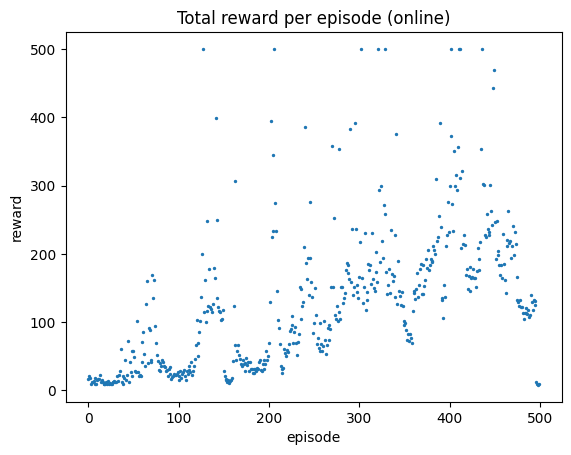

In [11]:
plt.scatter(np.arange(len(epsiode_rewards)), epsiode_rewards, s=2)
plt.title("Total reward per episode (online)")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()